<a href="https://colab.research.google.com/github/francji1/01ZLMA/blob/main/R/01ZLMA_ex09_LR_by_Tidymodels.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

01ZLMA - Exercise 09

Exercise 09 of the course 01ZLMA. 

# GLM for Discrete response - Logistic regression by Tidymodels

### Machine Learning approach vs.  Statistical approach

* In Python:  scikit-learn vs. statsmodels 

* In R: tidymodels (caret) vs.  classic R 




Load necessary packages:

In [ ]:
#install.packages("tidymodels")
#install.packages("vip")
#install.packages("broom")
#install.packages("skimr")
#install.packages("glmnet")

library(tidyverse)
library(knitr)
library(tidymodels)  
#library(vip)        
library(broom) 
library(skimr) 
library(glmnet)

In [ ]:
#install.packages("titanic")
library(titanic)
knitr::kable(head(titanic_train))

In [ ]:
titanic_train %>% mutate_if(is.character,as.factor) %>% summary()
titanic_test %>% mutate_if(is.character,as.factor) %>% summary()

In [ ]:
skim(titanic_train)
skim(titanic_test)

In [ ]:
data_train <- titanic_train %>%
 na_if("") %>%   # Take missing values as NA
 mutate_if(is.character,factor)%>%
 mutate(Relatives =  SibSp + Parch,
        Pclass = factor(Pclass),
        Survived = factor(Survived))  %>% 
  dplyr::select(-Name,-Cabin,-Ticket, -SibSp,-Parch ) 

data_test <- titanic_test %>%
 na_if("") %>%   # Take missing values as NA
 mutate_if(is.character,factor)%>%
 mutate(Relatives =  SibSp + Parch,
        Pclass = factor(Pclass))  %>% 
 dplyr::select(-Name,-Cabin,-Ticket, -SibSp,-Parch ) 

In [ ]:
str(data_train)
glimpse(data_train)

In [ ]:
# Number of NA's
colSums(is.na(data_train))
colSums(is.na(data_test))

In [ ]:
#install.packages("naniar")
#library(naniar)
#titanic_test %>%
#  dplyr::select(Age,Fare,Pclass,Sex,Embarked) %>%
#  gg_miss_upset()

Let's look at proportions of Survived passengers in train/test datasets

In [ ]:
dim(data_train)
dim(data_test)

data_train %>% 
  count(Survived ) %>% 
  mutate(prop = n/sum(n))

# We do not have Survived vairable in the testing data ...
  data_test %>% 
  count(Survived ) %>% 
  mutate(prop = n/sum(n))

## Logistic regression by Tidymodels

Based on case study by Julia Silge: https://www.tidymodels.org/start/case-study


https://www.tmwr.org/workflows.html





### Prepare Train-Validation datasets 



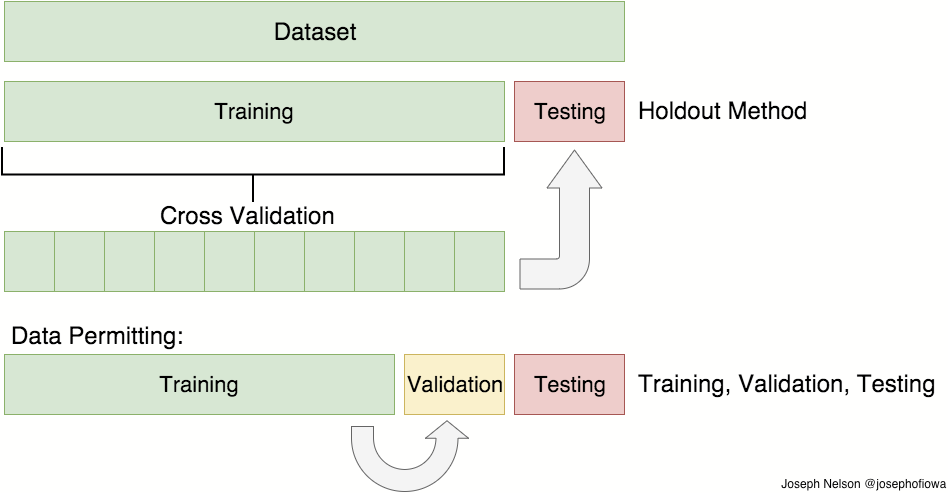

In our case, Testing dataset was created by Kaggle. Unfortunately, it's a dataset from the competition. To evaluate your model on this testing data, you have to upload your predictions on Kaggle. 

We will split the `titanic_train` data to train and validation set to keep 20% of traing data "blind for a moment".

In [ ]:
set.seed(42)
splits               <- initial_split(data_train, strata = Survived,prop = 0.80)
data_train0           <- training(splits)
data_validation0      <- testing(splits)

# training set proportions by Survived
data_train0 %>% 
  count(Survived) %>% 
  mutate(prop = n/sum(n))

# test set proportions by Survived
data_validation0  %>% 
  count(Survived) %>% 
  mutate(prop = n/sum(n))

It's important to use 'strata' to keep the same ration in train/validation/test samples

Now let's reserve  20% of the original `titanic_train` aka 'data_train' for our validation set.

In [ ]:
set.seed(42)
val_set <- validation_split(data_train, 
                            strata = Survived, 
                            prop = 0.80)


### Build the model

Let's specify a penalized logistic regression model using the lasso method.
Note that we define `penalty = tune()` so we can tune it in the next steps, and since we are using lasso method, we set `mixture = 1`.

In [ ]:
lr_mod <- 
  logistic_reg(penalty = tune(), mixture = 1) %>% 
  set_engine("glmnet")

In [ ]:
 # Check details about engines, mode, and penalty.
?logistic_reg

Different type of engines are described:
https://parsnip.tidymodels.org/reference/logistic_reg.html


### Create the recipe 


https://recipes.tidymodels.org/reference/index.html

Let's preprocess the data by creating a recipe:



Once we have the recipe defined, we can estimate the parameters needed to apply it using prep()
. In this case, that means finding the mean for height (fast) and training the nearest neighbor model to find gender and age (not so fast). Then we can use juice()
to get that imputed data back out. (If we wanted to apply the recipe to other data, like new data we hadn’t seen before, we would use bake()
instead.)

In [ ]:
impute_recipe <- recipe(Survived ~ ., data = data_train) %>%
  step_impute_mean(Age) %>%
  step_impute_knn(all_predictors()) %>%
   update_role(PassengerId, 
              new_role = "id")

In [ ]:
summary(impute_recipe)

In [ ]:
summary(data_train)
dim(data_train)

In [ ]:
train_imp <- impute_recipe %>% # use the recipe object
            prep() %>%      # perform the recipe on training data
            juice()         # extract only the preprocessed dataframe 
summary(train_imp)
dim(train_imp)

In [ ]:
test_imp <- impute_recipe %>% # use the recipe object
            prep() %>%       # perform the recipe on training data
            bake(new_data =data_test) 
summary(test_imp)


In [ ]:
# ? step_zv        # remove variables that contain only a single value
# ? step_normalize # normalize numeric data to have a standard deviation of one and a mean of zero
# ? step_dummy     # convert nominal data (e.g. character or factors) into one or more numeric binary model terms for the levels of the original data
# step_zv          # removes any numeric variables that have zero variance.
# step_corr        # will remove predictor variables that have large correlations with other predictor variables.
# step_novel       # will assign a previously unseen factor level to a new value.


In [ ]:
lr_recipe <- impute_recipe %>% 
   update_role(Survived, new_role = "outcome") %>%
   update_role(Pclass,Sex,Age,Fare,Embarked,Relatives  , new_role = "predictor") %>%
   update_role(PassengerId, new_role = "id") %>%
   #step_naomit(everything(), skip = TRUE) %>% 
   #step_novel(all_nominal(), -all_outcomes()) %>%
   step_normalize(all_numeric(), -all_outcomes(),-PassengerId) %>% 
   step_dummy(all_nominal(), -all_outcomes()) %>%
   step_zv(all_numeric(), -all_outcomes()) %>%
   step_corr(all_predictors(), threshold = 0.9, method = "spearman") 

In [ ]:
summary(lr_recipe)


In [ ]:
titanic_train_prep <-   lr_recipe %>% # use the recipe object
                        prep() %>% # perform the recipe on training data
                        juice() # extract only the preprocessed dataframe 

glimpse(titanic_train_prep)
summary(titanic_train_prep)

### Create the workflow

Let's bundle the model and recipe into a single `workflow()`:

In [ ]:
lr_workflow <- 
  workflow() %>% 
  add_recipe(lr_recipe) %>% 
  add_model(lr_mod) 


### Create the grid for tuning

Let's tune our model by creating a grid with 30 values for the hyperparameter we would like to tune. 

Penalty with `alpha=1` is the lasso penalty, and `alpha=0` the ridge penalty.

L1 x L2 regularization should only be used when you don’t understand the substance of your model very well and you want to  avoid overfitting.

In [ ]:
lr_reg_grid <- tibble(penalty = 10^seq(-4, -1, length.out = 30))
lr_reg_grid %>% top_n(-3) # lowest penalty values
lr_reg_grid %>% top_n(3)  # highest penalty values

### Train and tune the model

Let's train all these logistic regression models with 30 different hyperparameter values.
We provide the validation set `val_set`, so model diagnostics computed on `val_set` will be available after the fit.

In [ ]:
lr_res <- 
  lr_workflow %>% 
  tune_grid(val_set,
            grid = lr_reg_grid,
            control = control_grid(save_pred = TRUE, verbose = TRUE),
            metrics = metric_set(roc_auc, accuracy, sensitivity, specificity))
#lr_res

#metrics = metric_set(roc_auc, accuracy, sensitivity, specificity),


Collect metrices

In [ ]:
collect_metrics(lr_res) %>%
 pivot_wider(names_from = .metric, values_from = mean ) %>%
 arrange(desc(roc_auc))

Now visualize the validation set metrics by plotting the area under the ROC curve against the range of penalty values: 

In [ ]:
lr_plot <- 
  lr_res %>% 
  collect_metrics() %>% 
  mutate(metrics = factor(.metric)) %>%
  ggplot(aes(x = penalty, y = mean,color = metrics)) + 
  geom_point() + 
  geom_line() + 
  ylab("Area under the ROC Curve") +
  scale_x_log10(labels = scales::label_number())

lr_plot 

k-fold cross validation (does not work now, I have a mistake and do not know where ...)

In [ ]:
train_fold <- vfold_cv(data_train,strata = "Survived", v = 5)
summary(train_fold)
#train_fold

# adding parameters to workflow
lr_fold <- lr_workflow %>%
  tune_grid(
    resamples = train_fold,
    grid = lr_reg_grid,
    metrics = metric_set(roc_auc)
  )
 
 #lr_fold <- lr_workflow %>%
 # fit_resamples(
 #   resamples = train_fold,
 #   metrics = metric_set(roc_auc),
 #   control = control_resamples(save_pred = TRUE)
 # )

In [ ]:
collect_metrics(lr_fold) %>%
 pivot_wider(names_from = .metric, values_from = mean ) %>%
 arrange(desc(roc_auc))

Get the best values for this hyperparameter:

In [ ]:
top_models <-
  lr_res %>% 
  show_best("roc_auc", n = 15) %>% 
  arrange(desc(mean)) 
top_models

In [ ]:
top_models <-
  lr_res %>% 
  show_best("accuracy", n = 15) %>% 
  arrange(desc(mean)) 
top_models

Let's pick candidate with a best AUC.


In [ ]:
lr_best <- 
  lr_fold %>% 
  collect_metrics() %>% 
  arrange(desc(mean)) %>% 
  slice(1)
lr_best

In [ ]:
lr_res %>% 
  collect_predictions(parameters = lr_best)

And visualize the validation set ROC curve:

In [ ]:
lr_auc <- 
  lr_res %>% 
  collect_predictions(parameters = lr_best) %>% 
  roc_curve(Survived, .pred_0) %>% 
  mutate(model = "Logistic Regression - glmnet")

autoplot(lr_auc)

## Build the model in Tidymodels by hand (expert)

In [ ]:
train_imp %>% mutate_if(is.character,as.factor) %>% summary()
table(train_imp$Relatives)

data_train2 <- train_imp %>%
  transmute(survived = factor(Survived),
            fare  = cut(Fare, breaks=c(-Inf, 7,15,30,60,120, Inf),
             labels=c('very_low_fare', 'low_fare', 'medium_fare','moderate_fare', 'high_fare', 'very_high_fare')),
            age    = cut(Age, breaks=c(-Inf, 15, Inf), labels=c("child","adult")) ,
            class  = factor(Pclass),
            sex    = factor(Sex),
            embarked = factor(Embarked),
            relatives = cut(Relatives, breaks=c(-Inf, 0.5,1.5,2.5,4.5, Inf)) %>% factor())

summary(data_train2)           
str(data_train2)

In [ ]:
set.seed(42)
val2_set <- validation_split(data_train2, 
                            strata = survived, 
                            prop = 0.80)

In [ ]:
lr2_recipe <-  recipe(survived ~ ., data = data_train2) %>%
  #step_interact(terms = ~ sex:relatives) %>%
  #step_interact(terms = ~ fare:sex)  %>%
  step_dummy(all_nominal(), -all_outcomes())  
lr2_recipe
summary(lr2_recipe)
  


In [ ]:
data_train2_prep <-
  lr2_recipe %>% 
  prep() %>% 
  juice() 
 head(data_train2_prep) 



In [ ]:
# create all second order interactions (code for fun :-)
all_interactions <-  expand.grid(names(data_train2)[-1], 
                                 (names(data_train2)[-1])) %>%
  filter(Var1 != Var2) %>% 
  mutate(interact = paste0("(", Var1, " * ", Var2, ")")) %>% 
  pull(interact) %>% 
  paste0(sep = " + ") %>% 
  paste0(collapse = "") %>% 
  substr(1, nchar(.)-3)

formula(paste0("survived ~ ", paste0(names(data_train2)[-1], collapse = " + "), " + ", all_interactions))

In [ ]:
#Define model
lr2_mod <- 
  logistic_reg() %>% 
  set_engine("glm") %>% 
  set_mode("classification")
lr2_mod

#Define modelling workflow

lr_workflow2 <-
  workflow() %>% 
  add_model(lr2_mod) %>% 
  add_recipe(lr2_recipe)
lr_workflow2

In [ ]:
#Fit model
lr2_base <-
  lr_workflow2 %>% 
  fit(data = data_train2)

#Model performance:

lr2_base %>% 
  pull_workflow_fit() %>% 
  tidy() %>%
  kable(digits = 3)


In [ ]:
lr2_base %>% 
  pull_workflow_fit() %>% 
  glance()

In [ ]:
lr2_base %>% 
  pull_workflow_fit() %>% 
  summary() 

In [ ]:
lr2_base

In [ ]:
#? update_model()
lr_workflow2_mod2 <-
   workflow() %>% 
   add_model(lr2_mod) %>% 
   #remove_formula() %>%
   add_formula(survived ~ age+class+sex+relatives)

In [ ]:
#Fit model
lr2_mod2 <-
  lr_workflow2_mod2 %>% 
  fit(data = data_train2)

#Model performance:
lr2_mod2 %>% 
  pull_workflow_fit %>% 
  tidy()

In [ ]:
recipe_mod3 <- recipe(survived ~ age+class+sex+relatives,data = data_train2) %>%
  step_dummy(all_nominal(), -all_outcomes())  

lr_workflow2_mod3 <-
   workflow() %>% 
   add_model(lr2_mod) %>% 
   add_recipe(recipe_mod3)  

In [ ]:
train_fold2 <- vfold_cv(data_train2,strata = "survived", v = 5)
summary(train_fold2)
#train_fold

# adding parameters to workflow
lr_fold2 <- lr_workflow2_mod3 %>%
  tune_grid(
    resamples = train_fold2,
    metrics = metric_set(roc_auc,accuracy)
  )

In [ ]:
 lr_best2 <- 
  lr_fold2 %>% 
  collect_metrics()
  lr_best2

In [ ]:
lr2_res <- 
  lr_workflow2_mod3 %>% 
  tune_grid(val2_set,
            control = control_grid(save_pred = TRUE, verbose = TRUE),
            metrics = metric_set(roc_auc, accuracy, sensitivity, specificity))
#lr_res

In [ ]:
lr2_auc <- 
  lr2_res %>% 
  collect_predictions() %>% 
  roc_curve(survived, .pred_0) %>% 
  mutate(model = "Logistic Regression - glm")

autoplot(lr_auc)

In [ ]:
bind_rows(lr_auc, lr2_auc) %>% 
  ggplot(aes(x = 1 - specificity, y = sensitivity, col = model)) + 
  geom_path(lwd = 1.5, alpha = 0.8) +
  geom_abline(lty = 3) + 
  coord_equal() + 
  scale_color_viridis_d(option = "plasma", end = .6)

## More models to compare


In [ ]:
library(workflowsets)


In [ ]:
mod1_recipe <-  recipe(survived ~  ., data = data_train2) %>%
  step_dummy(all_nominal(), -all_outcomes())  

mod2_recipe <-  recipe(survived ~  age+class+sex+relatives+embarked, data = data_train2) %>%
  step_dummy(all_nominal(), -all_outcomes())  

mod3_recipe <-  recipe(survived ~  age+class+sex+relatives, data = data_train2) %>%
  step_dummy(all_nominal(), -all_outcomes())  

# ------------------------------------------------------------------------------
preproc <- 
  list(mod1 = mod1_recipe, 
       mod2 = mod2_recipe, 
       mod3 = mod3_recipe
  )

lr_mod <-
   logistic_reg() %>%
   set_engine("glm")

models <- list(logistic = lr_mod)
# ------------------------------------------------------------------------------


glm_models <- workflow_set(preproc, models, cross = T)
#glm_models

data_train2_folds <- vfold_cv(data_train2, v = 5)



In [ ]:
glm_models_res <-
   glm_models %>%
   workflow_map(resamples = data_train2_folds, grid = 10, seed = 2, verbose = TRUE)

In [ ]:
collect_metrics(glm_models_res)

In [ ]:
autoplot(glm_models_res, metric = "roc_auc")
autoplot(glm_models_res, metric = "accuracy")